## Clustering + PCA code
### TODO: Try to cluster without label (methoddeath), and then see how they corrospond

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["RedCapID", 'CaseCtrl', 'indexredcapid', 'Female', 'Age', 'Race',
       'Spanish', 'Month_Birth', 'Year_Birth', 'Month_Death',
       'Year_Death', 'EducationMax', 'EgoMaritalStatus', 'methoddeath',
       'violent']
# df = pd.read_csv('data/Test_Data_1102_enumerated.csv')
dffull = pd.read_csv('./data/Test_Data_1102_enumerated_filledin.csv')

In [7]:
df = dffull.drop(columns = ['RedCapID', 'indexredcapid',  'Month_Birth', 'Year_Birth', 'Month_Death','Year_Death', 'methoddeath'])
print(df.columns.values)

['CaseCtrl' 'Female' 'Age' 'Race' 'Spanish' 'EducationMax'
 'EgoMaritalStatus' 'violent' '276.5' '401.1' '250.2' '208.0' '318.0'
 '296.22' '761.0' '530.11' '300.1' '475.0' '465.0' '465.2' '840.0' '841.0'
 '835.0' '495.0' '296.2' '483.0' '773.0' '1009.0' '464.0' '591.0' '316.0'
 '285.0' '276.14' '296.1' '726.0' '665.0' '244.4' '317.1' '785.0' '561.1'
 '760.0' '745.0' '783.0' '512.9' '558.0' '830.0' '300.4' '916.0' '789.0'
 '480.0' '798.0' '216.0' '339.0' '939.0' '512.8' '300.0' '915.0' '819.0'
 '722.1' '418.0' '1010.0' '535.9' '455.0' '272.1' '722.6' '296.0' '479.0'
 '340.0' '721.1' '300.11' '457.0' '272.11' '351.0' '804.0' '278.1' '740.9'
 '512.7' '276.41' '593.0' '295.3' '870.3' '291.8' '740.1' '386.9' '687.4'
 '771.1' '532.0' '338.2' '600.0' '426.7' '297.2' '345.3' '788.0' '871.0'
 '427.3' '563.0' '317.0' '300.9' '327.3' '313.1' '530.1' '871.2' '300.12'
 '301.0' '338.1' '782.3' '967.0' '327.32' '276.12' '497.0' '979.0' '306.0'
 '327.4' '809.0' '716.9' '508.0' '585.1' '550.2' '562.1' 

In [8]:
## Standardize scores so PCA won't just weight the larger numbers
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df)

In [9]:
#fit pca
pca = PCA()
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Cumulative Explained Variance')

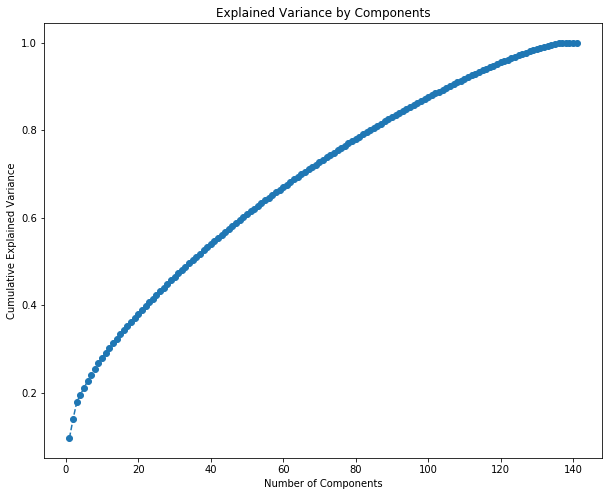

In [10]:
plt.figure(figsize = (10,8))
len_rat = len(pca.explained_variance_ratio_)+ 1
plt.plot(range(1, len_rat), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

### We want to keep around 80% of the variance- so choose 100

In [11]:
n_components = 100 #try a lower number since we have SO many
pca = PCA(n_components = n_components)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)

### Kmeans with PCA

In [12]:
#test number of clusters
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)


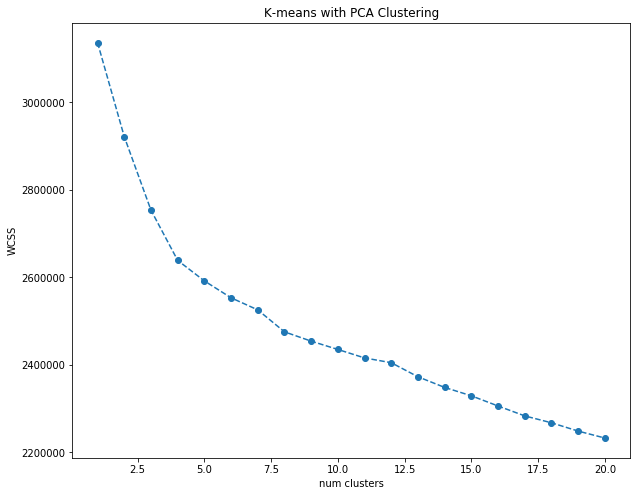

In [13]:
plt.figure(figsize = (10,8))
plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('num clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [16]:
## Pick the elbow from above- about 5?
## And fit!
n_clusters = 6 ##trying 6 for 6 methods death
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [22]:
#put the components and clusters into one big dataframe
df_segm_pca_kmeans = pd.concat([dffull.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-n_components:] = ["Component " + str(i) for i in range(1, n_components + 1)]
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [23]:
df_segm_pca_kmeans.head()

,RedCapID,CaseCtrl,indexredcapid,Female,Age,Race,Spanish,Month_Birth,Year_Birth,Month_Death,...,Component 92,Component 93,Component 94,Component 95,Component 96,Component 97,Component 98,Component 99,Component 100,Segment K-means PCA
0,25,0,1221372,1.0,98.564380,5.0,0.0,9.0,1903.0,4.0,...,-0.072196,0.157273,-0.073553,0.242352,-0.033483,0.102946,0.087804,-0.092400,-0.250151,0
1,210,0,1229858,0.0,88.608220,5.0,0.0,6.0,1918.0,1.0,...,-0.153999,0.326277,0.069809,0.399549,0.026812,0.147539,0.141445,-0.018835,-0.168373,0
2,500,0,1235588,1.0,35.039304,5.0,0.0,7.0,1957.0,1.0,...,0.064568,-0.078840,-0.048735,-0.119186,0.026518,0.027479,-0.060071,-0.017766,-0.084165,0
3,507,0,1220463,0.0,35.039304,5.0,0.0,10.0,1938.0,1.0,...,-0.040159,0.194007,0.110810,0.135985,0.133350,0.154018,0.000307,0.052874,-0.080679,0
4,610,0,1219461,1.0,35.039304,5.0,0.0,7.0,1950.0,1.0,...,0.045257,0.020390,-0.000586,-0.051311,0.092618,0.114946,-0.064605,0.001614,-0.134557,0


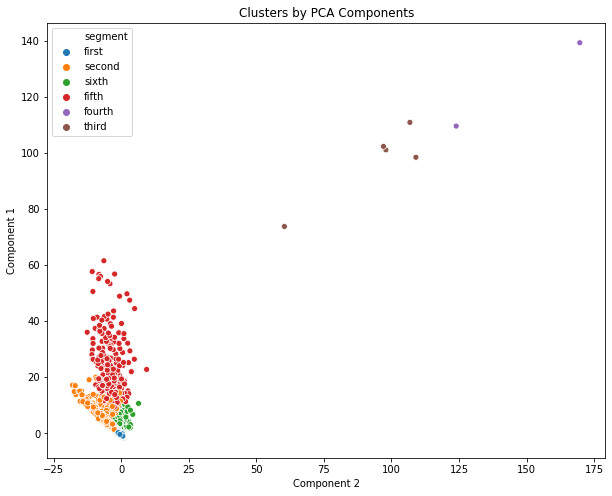

[-1.  1.  2.  3.  4.  7.]
[-1.  1.  2.  3.  4.  7.]


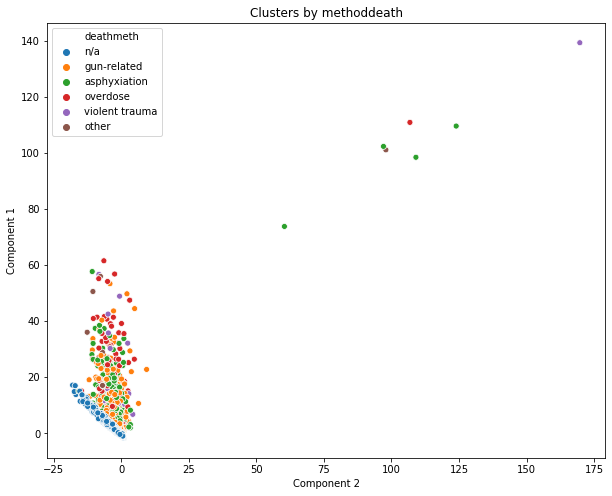

In [38]:
#Look at it!
import seaborn as sns

#map the color features
df_segm_pca_kmeans['deathmeth'] = df_segm_pca_kmeans['methoddeath'].map({-1: 'n/a',
                                                                            1: 'gun-related',
                                                                            2: 'asphyxiation',
                                                                            3: 'overdose',
                                                                            4: 'violent trauma',
                                                                            7: 'other'
                                                                        })
df_segm_pca_kmeans['segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'first',
                                                                            1: 'second',
                                                                            2: 'third',
                                                                            3: 'fourth',
                                                                            4: 'fifth',
                                                                            5: 'sixth'
                                                                        })

x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['deathmeth'])
plt.title('Clusters by methoddeath')
plt.show()

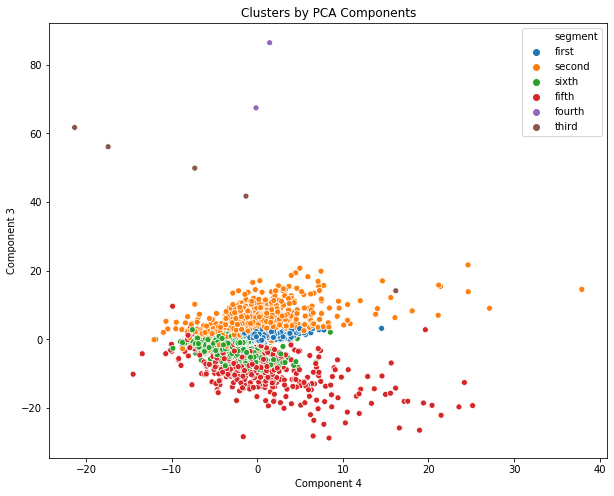

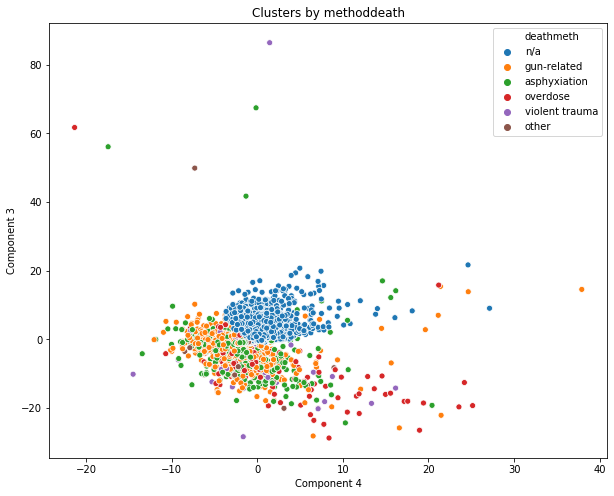

In [39]:
#try some more components views
x_axis = df_segm_pca_kmeans['Component 4']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_kmeans['Component 4']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['deathmeth'])
plt.title('Clusters by methoddeath')
plt.show()

In [40]:
#Check out what the cluster distributions look like
features = ['CaseCtrl', 'Female', 'Age', 'Race',
       'Spanish', 'Month_Birth', 'Year_Birth', 'Month_Death',
       'Year_Death', 'EducationMax', 'EgoMaritalStatus', 'methoddeath',
       'violent']
df_segm_pca_kmeans[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").mean()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0.000869,0.167902,38.289252,5.208855,-0.138248,2.567207,1.928115,-0.981543
1,0.107509,0.233387,33.564455,5.135602,0.069692,2.056186,2.063749,-0.660184
2,1.000000,0.400000,23.891506,5.200000,0.200000,1.800000,3.000000,3.200000
3,1.000000,0.500000,24.000000,5.000000,0.000000,2.000000,4.000000,3.000000
4,1.000000,0.301587,20.932726,5.050265,0.195767,1.788360,2.494709,2.089947
5,0.989172,0.156199,20.035055,4.891446,-0.126421,1.739036,2.028424,2.320249


In [41]:
#check the medians- better idea of centerpoints
df_segm_pca_kmeans[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").median()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
1,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
2,1,0.0,25.000000,5.0,0.0,2.0,3.0,2.0
3,1,0.5,24.000000,5.0,0.0,2.0,4.0,3.0
4,1,0.0,21.143835,5.0,0.0,2.0,2.0,2.0
5,1,0.0,20.000000,5.0,0.0,2.0,2.0,1.0


In [42]:
#cluster sizes
for i in np.unique(kmeans_pca.labels_):
    print(i, len(kmeans_pca.labels_[kmeans_pca.labels_ == i])/len(kmeans_pca.labels_))

0 0.7673506218368709
1 0.07261956137941858
2 0.0001961630507277649
3 7.846522029110597e-05
4 0.014829926635019027
5 0.1449252618776727


## Hierarchical Clustering

In [43]:
#do the clustering
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(scores_pca)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [44]:
df_segm_pca_agclust = pd.concat([dffull.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_agclust.columns.values[-n_components:] = ["Component " + str(i) for i in range(1, n_components + 1)]
df_segm_pca_agclust['Segment K-means PCA'] = cluster.labels_

In [45]:
df_segm_pca_agclust.head()

,RedCapID,CaseCtrl,indexredcapid,Female,Age,Race,Spanish,Month_Birth,Year_Birth,Month_Death,...,Component 92,Component 93,Component 94,Component 95,Component 96,Component 97,Component 98,Component 99,Component 100,Segment K-means PCA
0,25,0,1221372,1.0,98.564380,5.0,0.0,9.0,1903.0,4.0,...,-0.072196,0.157273,-0.073553,0.242352,-0.033483,0.102946,0.087804,-0.092400,-0.250151,0
1,210,0,1229858,0.0,88.608220,5.0,0.0,6.0,1918.0,1.0,...,-0.153999,0.326277,0.069809,0.399549,0.026812,0.147539,0.141445,-0.018835,-0.168373,0
2,500,0,1235588,1.0,35.039304,5.0,0.0,7.0,1957.0,1.0,...,0.064568,-0.078840,-0.048735,-0.119186,0.026518,0.027479,-0.060071,-0.017766,-0.084165,0
3,507,0,1220463,0.0,35.039304,5.0,0.0,10.0,1938.0,1.0,...,-0.040159,0.194007,0.110810,0.135985,0.133350,0.154018,0.000307,0.052874,-0.080679,0
4,610,0,1219461,1.0,35.039304,5.0,0.0,7.0,1950.0,1.0,...,0.045257,0.020390,-0.000586,-0.051311,0.092618,0.114946,-0.064605,0.001614,-0.134557,0


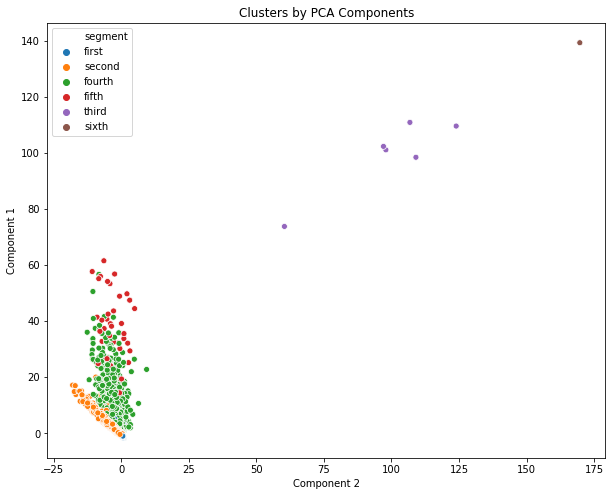

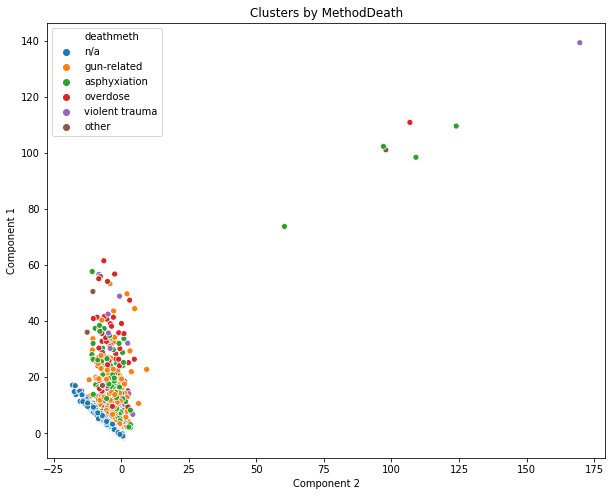

In [48]:
df_segm_pca_agclust['deathmeth'] = df_segm_pca_agclust['methoddeath'].map({-1: 'n/a',
                                                                            1: 'gun-related',
                                                                            2: 'asphyxiation',
                                                                            3: 'overdose',
                                                                            4: 'violent trauma',
                                                                            7: 'other'
                                                                        })
df_segm_pca_agclust['segment'] = df_segm_pca_agclust['Segment K-means PCA'].map({0: 'first',
                                                                            1: 'second',
                                                                            2: 'third',
                                                                            3: 'fourth',
                                                                            4: 'fifth',
                                                                            5: 'sixth'
                                                                        })

x_axis = df_segm_pca_agclust['Component 2']
y_axis = df_segm_pca_agclust['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_agclust['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_agclust['Component 2']
y_axis = df_segm_pca_agclust['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_agclust['deathmeth'])
plt.title('Clusters by MethodDeath')
plt.show()

In [49]:
for i in np.unique(cluster.labels_):
    print(i, len(cluster.labels_[cluster.labels_ == i])/len(cluster.labels_))


0 0.7459688493075445
1 0.2116991643454039
2 0.0002353956608733179
3 0.03989956451802738
4 0.0021577935580054143
5 3.9232610145552985e-05


In [50]:
#check out the cluster means
df_segm_pca_agclust[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").mean()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0.151783,0.159356,36.091909,5.149732,-0.148417,2.494951,1.920322,-0.451457
1,0.053744,0.213677,34.267244,5.211824,-0.057079,2.201631,2.018162,-0.825241
2,1.000000,0.333333,24.076255,5.166667,0.166667,2.000000,3.166667,3.000000
3,1.000000,0.200590,20.242774,4.956735,0.151426,1.668633,2.380531,1.826942
4,1.000000,0.363636,21.906150,5.145455,0.145455,1.854545,2.618182,2.181818
5,1.000000,1.000000,23.000000,5.000000,0.000000,1.000000,4.000000,4.000000


In [51]:
#cluster medians
df_segm_pca_agclust[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").median()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
1,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
2,1,0.0,25.000000,5.0,0.0,2.0,3.5,2.0
3,1,0.0,21.000000,5.0,0.0,2.0,2.0,2.0
4,1,0.0,22.000000,5.0,0.0,2.0,2.0,2.0
5,1,1.0,23.000000,5.0,0.0,1.0,4.0,4.0
